## 2017 US (WWEIA) Demand Estimation and Nutritional Mapping



In [1]:
!pip install -r requirements.txt

  Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl.metadata (1.6 kB)
  Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl.metadata (1.2 kB)
  Using cached eep153_tools-0.12.4-py2.py3-none-any.whl.metadata (363 bytes)
  Using cached python_gnupg-0.5.4-py2.py3-none-any.whl.metadata (2.0 kB)
  Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl.metadata (10 kB)
  Using cached fsspec-2025.3.2-py3-none-any.whl.metadata (11 kB)
Using cached cfedemands-0.6.4.dev0-py2.py3-none-any.whl (45 kB)
Using cached ConsumerDemands-0.4.3.dev0-py2.py3-none-any.whl (12 kB)
Using cached eep153_tools-0.12.4-py2.py3-none-any.whl (4.9 kB)
Using cached python_gnupg-0.5.4-py2.py3-none-any.whl (21 kB)
Using cached gspread_pandas-3.3.0-py2.py3-none-any.whl (27 kB)
Using cached fsspec-2025.3.2-py3-none-any.whl (194 kB)
  Attempting uninstall: gspread_pandas
    Found existing installation: gspread-pandas 2.2.3
    Uninstalling gspread-pandas-2.2.3:
      Successfully uninstalled gspread-pandas-2

In [2]:
US_Data = "1OWluIYUGkmR6iFgSzJJa2ikEqqMT6BHbsKZyip236HU"

In [3]:
import pandas as pd
import numpy as np
from eep153_tools.sheets import read_sheets

# Change 'Uganda_Data' to key of your own sheet in Sheets, above
x = read_sheets(US_Data,sheet='Food Expenditures 2017')
x["j"] = x["food_name"]
x = x.set_index(['i','t','m','j'])["grams"].squeeze()


# Now prices
#p = read_sheets(Uganda_Data,sheet='Food Prices (2019-20)').set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
#p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
#p = p.xs('Kg',level="u").squeeze().unstack('j')

# Drop prices for goods we don't have expenditures for
#p = p[x.index.levels[-1]].T

# Household characteristics
d = read_sheets(US_Data,sheet="Household Characteristics 2017")
d.columns.name = 'k'
d["sex"] = d["sex"].map({"Female": 1, "Male": 0})
d['log_household'] = np.log(d['HH_size'])
d.drop("HH_size", axis= 1, inplace=True)

# Fill blanks with zeros
d = d.replace(np.nan,0)

# Expenditures x may have duplicate columns
x = x.T.groupby(['i','t','m','j']).sum()
x = x.replace(0,np.nan) # Replace zeros with missing

# Take logs of expenditures; call this y
y = np.log(x)
d.set_index(['i','t','m'],inplace=True)


In [4]:
x.shape

(90069,)

In [5]:
x.unstack("j")

,,j,3 musketeers bar,Agave liquid sweetener,"Air filled fritter or fried puff, without syrup, puerto rica",Alcoholic malt beverage,"Alcoholic malt beverage, sweetened",Alexander,"Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond butter, lower sodium",...,"Yogurt, ns as to type of milk, flavors other than fruit","Yogurt, ns as to type of milk, fruit","Yogurt, ns as to type of milk, plain","Yogurt, whole milk, baby food","Yogurt, whole milk, baby food, with fruit and multigrain cer","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain",Yuca fries,Zwieback toast
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705,2017,USA,51.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93706,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93707,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93708,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99146,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99149,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
y.head()

i      t     m    j                                        
93704  2017  USA  Apple juice, 100%                            5.448890
                  Applesauce, flavored                         4.730921
                  Asparagus, fresh, cooked, no added fat       2.420368
                  Cereal (general mills cheerios honey nut)    3.323236
                  Cheese, mozzarella, part skim                3.344627
Name: grams, dtype: float64

### Estimation



Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$
We have data on `y` (log expenditures) and `d` (household characteristics).  This leaves the rest of the elements for us to estimate.



#### Basic Estimation



Just one line to set up the regression:



In [7]:
y

i      t     m    j                                              
93704  2017  USA  Apple juice, 100%                                  5.448890
                  Applesauce, flavored                               4.730921
                  Asparagus, fresh, cooked, no added fat             2.420368
                  Cereal (general mills cheerios honey nut)          3.323236
                  Cheese, mozzarella, part skim                      3.344627
                                                                       ...   
99152  2017  USA  Roll, white, soft                                  3.761200
                  Swiss steak                                        5.135798
                  Thuringer                                          5.620401
                  Vegetable beef soup, canned, prepared with milk    5.544200
                  Vegetable beef soup, home recipe                   5.515604
Name: grams, Length: 90069, dtype: float64

In [8]:
d

,,k,age,sex,log_household
i,t,m,,,
93703,2017,USA,2.0,1,1.609438
93704,2017,USA,2.0,0,1.386294
93705,2017,USA,66.0,1,0.000000
93706,2017,USA,18.0,0,1.609438
93707,2017,USA,13.0,0,1.945910
...,...,...,...,...,...
102952,2017,USA,70.0,1,0.693147
102953,2017,USA,42.0,0,0.000000
102954,2017,USA,41.0,1,1.945910


In [9]:

food_counts = y.groupby('j').count()
top_foods = food_counts.sort_values(ascending=False).head(350).index
x_filtered = x[x.index.get_level_values('j').isin(top_foods)]
y_filtered = y[y.index.get_level_values('j').isin(top_foods)] #used the top 350 foods to prevent regression issues

# Step 3.2: Random sample of 500 households
sample_ids = y_filtered.index.get_level_values('i').unique().to_series().sample(1750, random_state=42)

# Sample dataframes used for testing purposes only 
# Filter y and d to match
y_sample = y_filtered[y_filtered.index.get_level_values('i').isin(sample_ids)]
d_sample = d[d.index.get_level_values('i').isin(sample_ids)]

# Final checks
print("Shape of y_sample:", y_sample.shape)
print("Shape of d_sample:", d_sample.shape)

Shape of y_sample: (21995,)
Shape of d_sample: (1750, 3)


In [10]:
d

,,k,age,sex,log_household
i,t,m,,,
93703,2017,USA,2.0,1,1.609438
93704,2017,USA,2.0,0,1.386294
93705,2017,USA,66.0,1,0.000000
93706,2017,USA,18.0,0,1.609438
93707,2017,USA,13.0,0,1.945910
...,...,...,...,...,...
102952,2017,USA,70.0,1,0.693147
102953,2017,USA,42.0,0,0.000000
102954,2017,USA,41.0,1,1.945910


In [11]:
y.unstack("j")

,,j,3 musketeers bar,Agave liquid sweetener,"Air filled fritter or fried puff, without syrup, puerto rica",Alcoholic malt beverage,"Alcoholic malt beverage, sweetened",Alexander,"Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond butter, lower sodium",...,"Yogurt, ns as to type of milk, flavors other than fruit","Yogurt, ns as to type of milk, fruit","Yogurt, ns as to type of milk, plain","Yogurt, whole milk, baby food","Yogurt, whole milk, baby food, with fruit and multigrain cer","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain",Yuca fries,Zwieback toast
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93705,2017,USA,3.931826,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93706,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93707,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
93708,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99146,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99149,2017,USA,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [12]:
from cfe import Regression

result = Regression(y=y_filtered, d=d, min_prop_items= 0.00001) 

And then one line to predict expenditures and estimate most of the things we need:



In [13]:
result.predicted_expenditures()

i      t     m    j                               
93704  2017  USA  Apple, raw                            41.710866
                  Banana, raw                           76.242971
                  Bread, white                          34.725692
                  Carrots, raw                           0.616009
                  Cheese, american                      14.220104
                                                         ...     
99152  2017  USA  Sugar, white, granulated or lump      18.784868
                  Tomatoes, for use on a sandwich       22.991018
                  Tomatoes, raw                        175.691750
                  Water, bottled, unsweetened         1698.586413
                  Water, tap                          1780.478757
Length: 113958, dtype: float64

### Predicted log expenditures vs actual:



<Axes: xlabel='yhat', ylabel='y'>

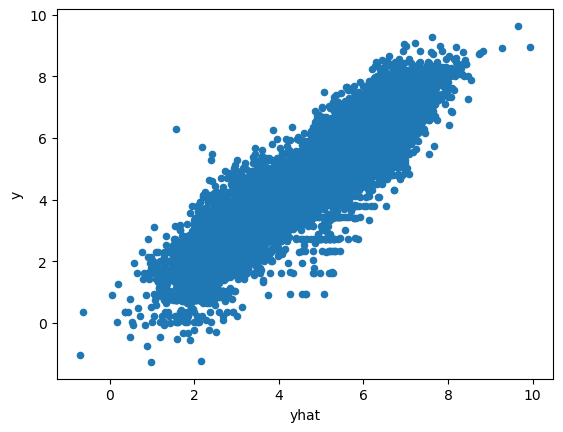

In [14]:
%matplotlib inline
df = pd.DataFrame({'y':y,'yhat':result.get_predicted_log_expenditures()})
df.plot.scatter(x='yhat',y='y')

#### Parameters



##### (Relative) Income Elasticity



Some of the parameters have an interesting interpretation.  First among these are the $\beta$ coefficients, which govern how *income elastic* different goods are (higher values means more elastic).  These are also called *Frisch elasticities*.
Here we use a plot to visualize, with confidence intervals.



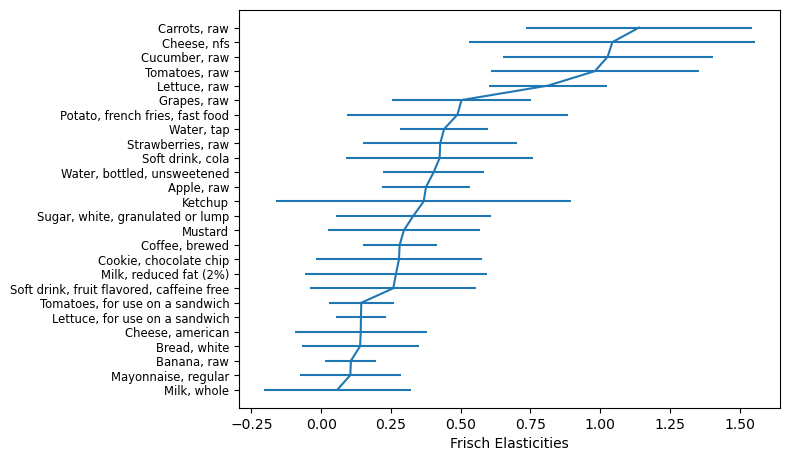

In [15]:
ax = result.graph_beta()

To just see the values of $\beta$:



In [16]:
result.get_beta()

j
Apple, raw                                   0.375823
Banana, raw                                  0.106715
Bread, white                                 0.139589
Carrots, raw                                 1.138640
Cheese, american                             0.141835
Cheese, nfs                                  1.043444
Coffee, brewed                               0.281274
Cookie, chocolate chip                       0.278897
Cucumber, raw                                1.026858
Grapes, raw                                  0.503112
Ketchup                                      0.367410
Lettuce, for use on a sandwich               0.142565
Lettuce, raw                                 0.813291
Mayonnaise, regular                          0.104381
Milk, reduced fat (2%)                       0.268098
Milk, whole                                  0.058340
Mustard                                      0.296393
Potato, french fries, fast food              0.488427
Soft drink, cola          

##### Demand and Household Composition



We&rsquo;re particularly interested in the effects of household composition on demand.  These are captured by the $\gamma_j$ parameters in the regression.



In [17]:
result.get_gamma()

k,age,sex,log_household,Constant
j,,,,
"Apple, raw",0.003059,-0.192426,0.016900,5.018679
"Banana, raw",0.002676,-0.120820,0.027885,4.722995
"Bread, white",-0.000725,-0.102885,-0.035676,3.938392
"Carrots, raw",-0.009904,-0.187517,-0.105184,3.237518
"Cheese, american",0.005139,-0.111494,0.063676,3.200868
"Cheese, nfs",-0.001172,-0.305766,-0.029136,2.817402
"Coffee, brewed",0.003209,-0.276431,-0.168539,5.870104
"Cookie, chocolate chip",0.004246,-0.241564,-0.082973,3.559912
"Cucumber, raw",-0.000008,-0.245715,-0.051110,3.822893


In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

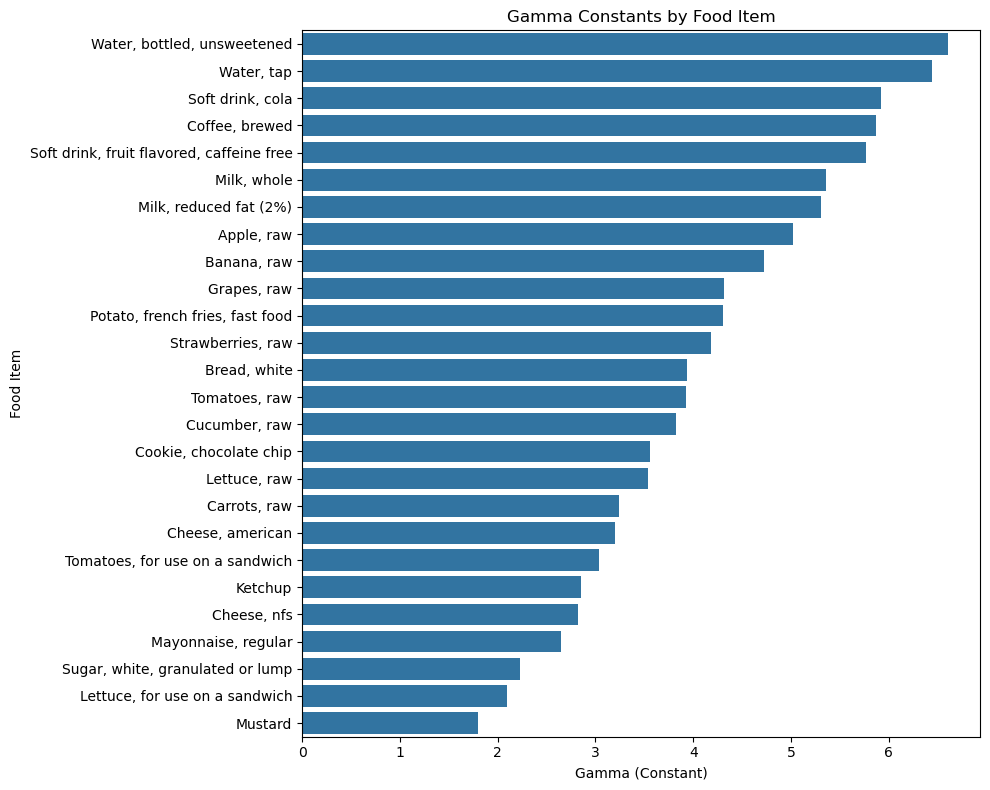

In [19]:
gamma = result.get_gamma()
gamma_sorted = gamma.sort_values(by="Constant", ascending=False)
plt.figure(figsize=(10, 8))
sns.barplot(data=gamma_sorted, x="Constant", y="j")
plt.xlabel("Gamma (Constant)")
plt.ylabel("Food Item")
plt.title("Gamma Constants by Food Item")
plt.tight_layout()
plt.show()

In [20]:
gamma = result.get_gamma()
gamma[["Constant"]].sort_values("Constant")

k,Constant
j,
Mustard,1.797716
"Lettuce, for use on a sandwich",2.096294
"Sugar, white, granulated or lump",2.226951
"Mayonnaise, regular",2.647917
"Cheese, nfs",2.817402
Ketchup,2.854315
"Tomatoes, for use on a sandwich",3.031757
"Cheese, american",3.200868
"Carrots, raw",3.237518


##### Welfare



Another import quantity we estimate is $w_i$.  This is a welfare measure for the household.  Here&rsquo;s a histogram:



<Axes: ylabel='Density'>

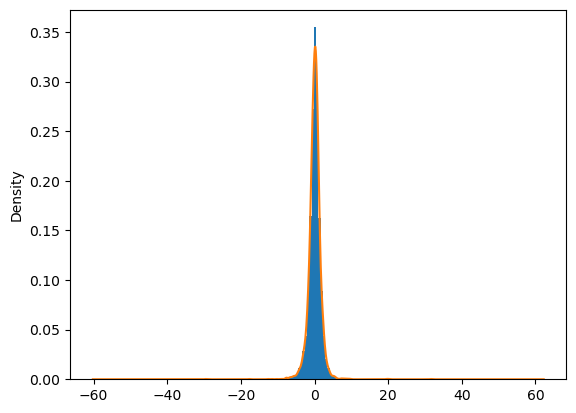

In [21]:
ax = result.get_w().plot.hist(bins=100,density=True)
result.get_w().plot.kde(ax=ax)

In [22]:
result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)]

i      t     m  
93704  2017  USA   -3.700756
93705  2017  USA   -1.228227
93706  2017  USA    0.238115
93707  2017  USA   -0.548237
93708  2017  USA   -0.900486
                      ...   
99145  2017  USA    0.514496
99146  2017  USA   -6.621879
99149  2017  USA   -0.575562
99151  2017  USA   -0.228766
99152  2017  USA    0.996158
Length: 4341, dtype: float64

<Axes: ylabel='Density'>

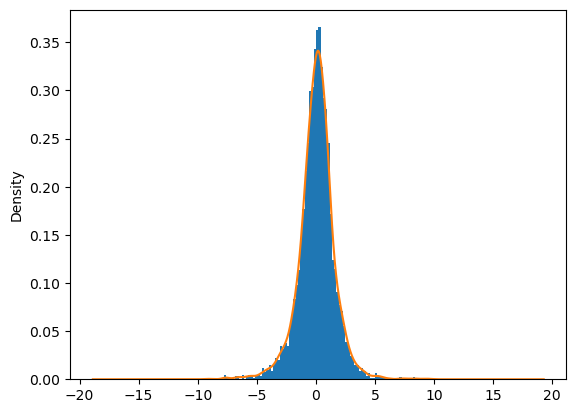

In [23]:
ax = result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)].plot.hist(bins=100,density=True)
result.get_w()[(result.get_w() > -10) & (result.get_w() < 10)].plot.kde(ax=ax)

#### Saving Result



In [24]:
result.to_pickle('us_estimates_2017.rgsn')

In [25]:
import cfe
result = cfe.regression.read_pickle('us_estimates_2017.rgsn')

#### Demand and Utility



Having estimated the demand system, we can examine the implied demand curves.



##### Budgets



Get food budget for all households, then find median budget:



In [26]:
p = pd.read_csv("proj3_min_cost_data - prices.csv")

# data cleaning to match 

p["u"] = "Kg"
p["m"] = "USA"
p["price"] = p["price"] * 10
p = p[p["t"] == "2017/2018"]

codes = pd.read_csv("proj3_min_cost_data - recipes.csv")

codes = codes[["parent_foodcode", "parent_desc"]]
c = codes.groupby("parent_foodcode").first()
c.rename(columns = {"parent_foodcode": "j"})
p = p.join(c, on="j") 
p = p.drop("j", axis=1)
p = p.rename(columns = {"parent_desc":"j"})
p = p.set_index(['t','m','j','u'])

# Compute medians of prices for particular time, place and unit
p = p.groupby(['t','m','j','u']).median()

# Just keep metric units
p = p.xs('Kg',level="u").squeeze().unstack('j')


# Identify the common keys between x_filtered.index.levels[-1] and p.columns
common_keys = p.columns.intersection(x_filtered.index.levels[-1])

# Now subset p with these keys and transpose the result.
p = p[common_keys].T


In [27]:
import numpy as np

xhat = result.predicted_expenditures()

# Total food expenditures per household
xbar = xhat.groupby(['i','t','m']).sum()

# Reference budget
xref = xbar.quantile(0.5)  # Household at 0.5 quantile is median

In [28]:
# Reference prices chosen from a particular time; average across place.
# These are prices per kilogram:
pbar = p.mean(axis=1)
#pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

common_keys = pbar.index.intersection(result.beta.index)
pbar = pbar.loc[common_keys]
pbar = pbar.replace(np.nan, 1)

# Replace missing prices with 1 (this is because they're best measured in expenditures)
pbar = pbar.replace(np.nan,1)

#Finally, define a function to change a single price in the vector $p$:
def my_prices(p0,j,p=pbar):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

common_keys

Index(['Apple, raw', 'Banana, raw', 'Bread, white', 'Carrots, raw',
       'Coffee, brewed', 'Cookie, chocolate chip', 'Cucumber, raw',
       'Grapes, raw', 'Ketchup', 'Lettuce, for use on a sandwich',
       'Lettuce, raw', 'Mayonnaise, regular', 'Milk, reduced fat (2%)',
       'Milk, whole', 'Mustard', 'Potato, french fries, fast food',
       'Soft drink, cola', 'Soft drink, fruit flavored, caffeine free',
       'Strawberries, raw', 'Sugar, white, granulated or lump',
       'Tomatoes, for use on a sandwich', 'Tomatoes, raw',
       'Water, bottled, unsweetened', 'Water, tap'],
      dtype='object', name='j')

##### Demand as a function of prices



Let&rsquo;s take a look at demand schedules for households with different budgets. Here are the demand curves for french fries.



Text(0.5, 0, 'Quantities of Potato, french fries, fast food Demanded')

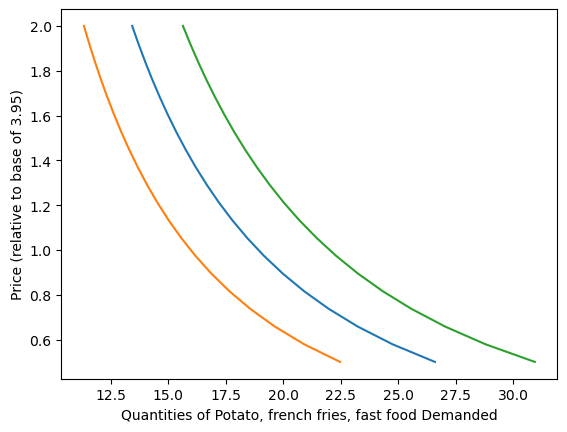

In [29]:
import matplotlib.pyplot as plt
%matplotlib inline

use = 'Potato, french fries, fast food'  # Good we want demand curve for
pbar = pbar.reindex(result.beta.index).fillna(1)
# Vary prices from 50% to 200% of reference.
scale = np.linspace(.5,2,20)

# Demand for Millet for household at median budget
plt.plot([result.demands(xref,my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 25% percentile
plt.plot([result.demands(xbar.quantile(0.25),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

# Demand for Millet for household at 75% percentile
plt.plot([result.demands(xbar.quantile(0.75),my_prices(pbar[use]*s,use,pbar))[use] for s in scale],scale)

plt.ylabel(f"Price (relative to base of {pbar[use]:.2f})")
plt.xlabel(f"Quantities of {use} Demanded")

##### Engel Curves



Engel curves trace out how demand changes with budget:



Text(0.5, 1.0, 'Engel Curves')

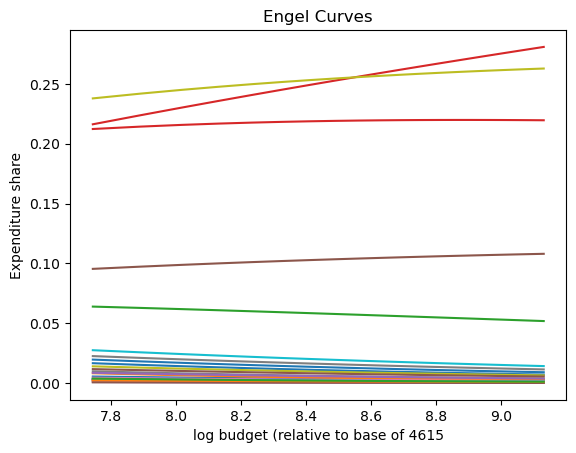

In [30]:
fig,ax = plt.subplots()

ax.plot(np.log(scale*xref),[result.expenditures(s*xref,pbar)/(s*xref) for s in scale])
ax.set_xlabel(f'log budget (relative to base of {xref:.0f}')
ax.set_ylabel(f'Expenditure share')
ax.set_title('Engel Curves')

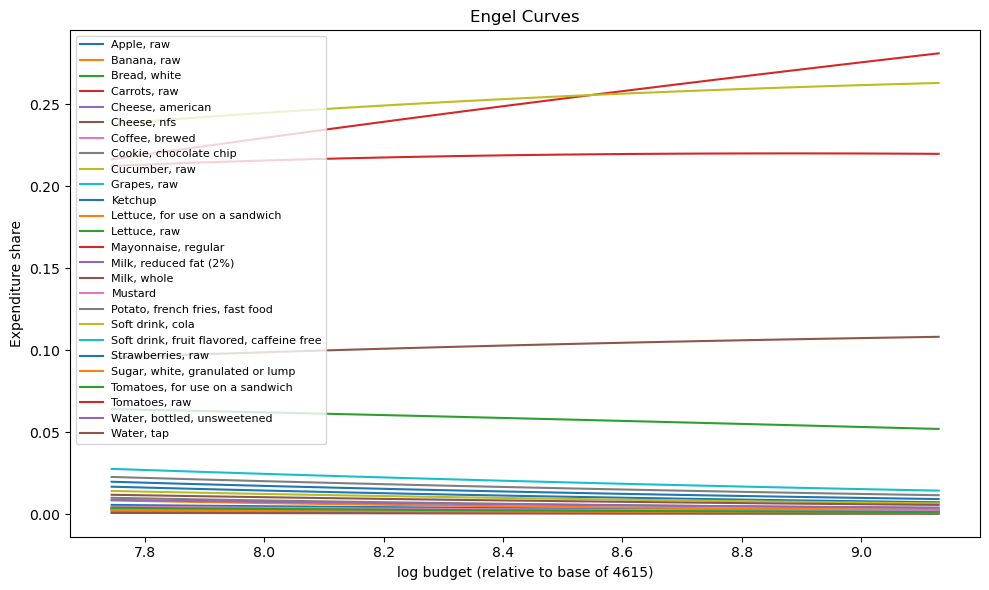

In [31]:
fig, ax = plt.subplots(figsize=(10, 6))

# Create a range of budgets by scaling the base budget xref.
scale = np.linspace(0.5, 2, 20)

# Loop over each good in pbar.
for good in pbar.index:
    shares = []
    for s in scale:
        budget = s * xref  # Adjust budget by the scale factor.
        # Compute expenditures for all goods at this budget.
        exp_series = result.expenditures(budget, pbar)
        # Compute the expenditure share for the current good.
        share = exp_series[good] / budget
        shares.append(share)
    # Plot the Engel curve for the current good,
    # using the log-budget (log(scale * xref)) on the x-axis.
    ax.plot(np.log(scale * xref), shares, label=good)

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves')

# Add a legend to label each curve with the good’s name.
ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()

### Engel curves for selected foods with a large share of expenditure

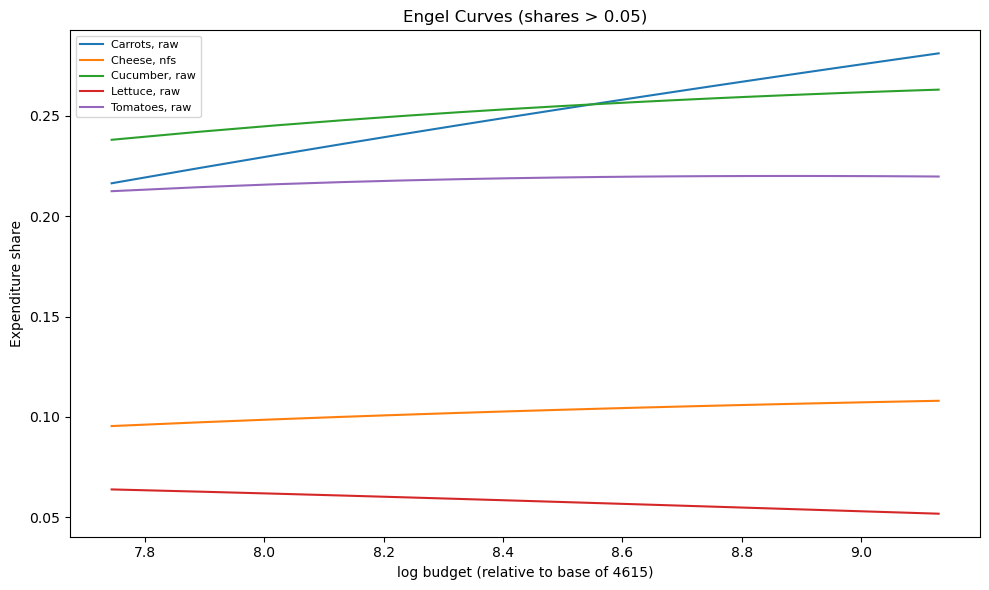

In [32]:
import matplotlib.pyplot as plt
import numpy as np

fig, ax = plt.subplots(figsize=(10, 6))

# Define a range of multipliers to vary the base budget.
scale = np.linspace(0.5, 2, 20)

# Loop over each good in pbar (which is assumed to be a Series indexed by good names).
for good in pbar.index:
    shares = []
    # Compute the expenditure share for each scaled budget.
    for s in scale:
        budget = s * xref  # Adjust the base budget.
        exp_series = result.expenditures(budget, pbar)
        share = exp_series[good] / budget
        shares.append(share)
    # Filter: plot only if the maximum share exceeds 0.05.
    if max(shares) > 0.05:
        ax.plot(np.log(scale * xref), shares, label=good)

ax.set_xlabel(f'log budget (relative to base of {xref:.0f})')
ax.set_ylabel('Expenditure share')
ax.set_title('Engel Curves (shares > 0.05)')
ax.legend(fontsize=8, loc='best')

plt.tight_layout()
plt.show()


##### Indirect Utility



Text(0.5, 1.0, 'Indirect Utility Function')

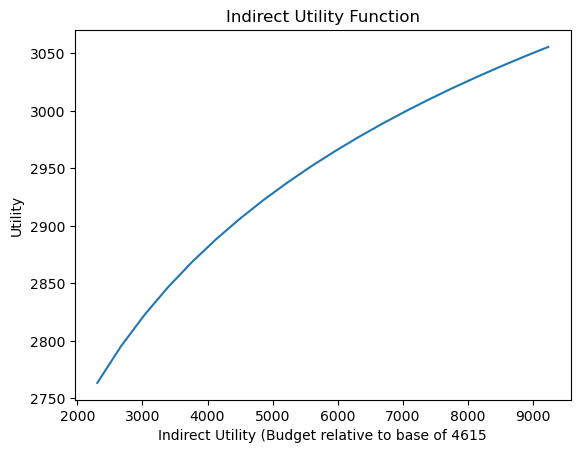

In [33]:
fig,ax = plt.subplots()

ax.plot(scale*xref,[result.indirect_utility(s*xref,pbar) for s in scale])
ax.set_xlabel(f'Indirect Utility (Budget relative to base of {xref:.0f}')
ax.set_ylabel(f'Utility')
ax.set_title('Indirect Utility Function')

# Nutrition Data




In [34]:
xhat.unstack('j')

,,j,"Apple, raw","Banana, raw","Bread, white","Carrots, raw","Cheese, american","Cheese, nfs","Coffee, brewed","Cookie, chocolate chip","Cucumber, raw","Grapes, raw",...,Mustard,"Potato, french fries, fast food","Soft drink, cola","Soft drink, fruit flavored, caffeine free","Strawberries, raw","Sugar, white, granulated or lump","Tomatoes, for use on a sandwich","Tomatoes, raw","Water, bottled, unsweetened","Water, tap"
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,41.633222,76.178135,34.674084,0.615701,14.254750,0.463451,139.795226,14.332181,1.247244,13.850858,...,2.218448,14.431983,82.106735,131.311159,17.128228,3.192431,12.982435,1.382599,151.657058,114.655978
93705,2017,USA,103.341551,100.356652,44.314235,5.232001,23.032562,4.351486,329.720034,33.025148,13.256890,52.884891,...,4.317486,48.015041,244.160894,307.327131,55.296736,8.833598,16.566053,19.327699,680.481528,660.920461
93706,2017,USA,192.852923,121.809002,58.924408,45.514614,27.445265,27.541224,429.155910,45.171362,70.391191,103.729641,...,7.216576,106.424473,471.896919,387.136676,89.947856,12.373864,23.390711,70.312740,880.594320,728.752639
93707,2017,USA,142.137015,111.557489,52.358283,18.855207,24.444165,12.076077,319.860578,34.536127,30.859316,68.551060,...,5.626246,70.864226,327.599744,300.631959,62.343840,9.303362,20.792034,31.801793,619.407340,477.340043
93708,2017,USA,118.264791,105.957053,45.255586,7.064375,25.217315,6.003249,321.695891,34.163682,17.914918,61.449866,...,4.660846,56.405712,277.181831,317.853953,59.609675,9.699439,17.433236,26.575464,801.830728,711.921888
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,205.625445,121.457669,61.465751,70.260219,26.871281,37.157510,430.049691,45.285137,92.634495,115.008439,...,7.663450,114.215693,492.892113,382.623349,99.575344,12.825166,23.920491,87.062635,861.166548,717.392791
99146,2017,USA,13.888673,55.776101,23.063141,0.022124,9.419402,0.021992,61.469622,6.345931,0.062123,3.185772,...,0.933335,3.464929,23.760020,61.722729,4.926499,1.216812,8.529068,0.078668,46.768519,31.645041
99149,2017,USA,112.562383,95.970590,47.401828,16.729857,20.689615,8.746616,233.148363,25.799742,23.470424,61.021346,...,4.592311,49.519081,226.528885,230.339376,61.136069,8.337064,16.936077,28.161246,511.072283,423.532588


In [35]:
p

t,2017/2018
m,USA
j,
Agave liquid sweetener,8.52492
"Alcoholic malt beverage, sweetened",3.76661
"Alfalfa sprouts, raw",16.21247
Alfredo sauce,5.03620
Almond butter,17.66285
...,...
"Yogurt, nonfat milk, plain",4.12198
"Yogurt, whole milk, baby food",5.95216


In [36]:
p_new = pd.read_csv("proj3_min_cost_data - prices.csv")
p_new["u"] = "Kg"

p_new["m"] = "USA"

p_new["price"] = p_new["price"] * 10

p_new = p_new[p_new["t"] == "2017/2018"]


p_new = p_new.join(c, on="j") 
p_new = p_new.drop("j", axis=1)
p_new = p_new.drop("t", axis=1)
p_new = p_new.drop("u", axis=1)
p_new = p_new.rename(columns = {"parent_desc":"j"})

p_new

,m,price,j
10577,USA,1.00484,"Milk, NFS"
10578,USA,0.98280,"Milk, whole"
10579,USA,0.92085,"Milk, reduced fat (2%)"
10580,USA,0.90914,"Milk, low fat (1%)"
10581,USA,0.92441,"Milk, fat free (skim)"
...,...,...,...
15007,USA,1.20958,Sports drink (Gatorade G)
15008,USA,0.91942,Sports drink (Powerade)
15009,USA,1.14084,"Sports drink, low calorie (Gatorade G2)"
15010,USA,0.89002,"Sports drink, low calorie (Powerade Zero)"


In [37]:
p_pivot = p_new.pivot_table(
    index=["m"],   # or ["m", "t"] if you prefer that order
    columns="j",
    values="price",
    aggfunc="sum"      # or another aggregation if you have duplicates
)

p_pivot

j,100 GRAND Bar,3 MUSKETEERS Bar,"Adobo, with noodles","Adobo, with rice",Agave liquid sweetener,"Alcoholic malt beverage, sweetened","Alfalfa sprouts, raw",Alfredo sauce,Almond butter,"Almond milk, sweetened",...,"Yogurt, low fat milk, plain","Yogurt, nonfat milk, flavors other than fruit","Yogurt, nonfat milk, fruit","Yogurt, nonfat milk, plain","Yogurt, soy","Yogurt, whole milk, baby food","Yogurt, whole milk, flavors other than fruit","Yogurt, whole milk, fruit","Yogurt, whole milk, plain","Zucchini soup, cream of, prepared with milk"
m,,,,,,,,,,,,,,,,,,,,,
USA,10.2129,12.5797,6.74801,6.38532,8.52492,3.76661,16.21247,5.0362,17.66285,1.69743,...,4.12198,5.28725,4.35241,4.12198,9.19396,5.95216,5.28725,4.35241,4.12198,2.44685


In [38]:
# Expenditures divided by prices/kg gives quantities in kgs...
xhat_unstacked = xhat.unstack('j')
xhat_unstacked_aligned = xhat_unstacked.reindex(index=p_pivot.index, columns=p_pivot.columns)
common_columns = xhat_unstacked_aligned.columns.intersection(p_pivot.columns)
common_index = xhat_unstacked_aligned.index.intersection(p_pivot.index)

p_pivot_aligned = p_pivot.loc[common_index, common_columns]

qhat = (xhat_unstacked/p_pivot_aligned).dropna(how='all')

# Drop missing columns
qhat = qhat.loc[:,qhat.count()>0]

In [39]:
nutrients = pd.read_csv("proj3_min_cost_data - nutrients.csv")
recipes = pd.read_csv("proj3_min_cost_data - recipes.csv")

# from fndds diet problem: normalize weights to percentage terms. 
recipes['ingred_wt'] = recipes['ingred_wt']/recipes.groupby(['parent_foodcode'])['ingred_wt'].transform("sum")

# we're going to extend the recipes data frame to include the nutrient profiles of its ingredients (in 100g)
df = recipes.merge(nutrients, how="left", on="ingred_code")

# multiply all nutrients per 100g of an ingredient by the weight of that ingredient in a recipe.
numeric_cols = list(df.select_dtypes(include=["number"]).columns)
numeric_cols.remove("ingred_wt")
df[numeric_cols] = df[numeric_cols].mul(df["ingred_wt"], axis=0)
df = df.rename(columns={'parent_desc': 'j'})

# sum nutrients of food codes (over the multiple ingredients)
# python tip: one can merge dictionaries dict1 dict2 using **, that is: dict_merge = {**dict1, **dict2}. 
#The ** effectively "unpacks" the key value pairs in each dictionary
df = df.groupby('j').agg({**{col: "sum" for col in numeric_cols},
                                        "j": "first"})
df.drop("parent_foodcode", axis = 1, inplace=True)
df.drop("ingred_code", axis = 1, inplace=True)
df.drop("j", axis = 1, inplace=True)

df.index.name = "j"

fct = df


In [40]:
fct.index

Index(['100 GRAND Bar', '3 MUSKETEERS Bar', '3 Musketeers Truffle Crisp Bar',
       'Abalone, cooked, NS as to cooking method',
       'Abalone, floured or breaded, fried', 'Abalone, steamed or poached',
       'Adobo, with noodles', 'Adobo, with rice', 'Agave liquid sweetener',
       'Air filled fritter or fried puff, without syrup, Puerto Rican style',
       ...
       'Yogurt, whole milk, plain', 'Yokan', 'Youngberries, raw', 'Yuca fries',
       'Zabaglione', 'Zombie', 'Zucchini lasagna, diet frozen meal',
       'Zucchini soup, cream of, prepared with milk', 'Zucchini, pickled',
       'Zwieback toast'],
      dtype='object', name='j', length=8886)

In [41]:
qhat.columns

Index(['Apple, raw', 'Banana, raw', 'Bread, white', 'Carrots, raw',
       'Coffee, brewed', 'Cookie, chocolate chip', 'Cucumber, raw',
       'Grapes, raw', 'Ketchup', 'Lettuce, for use on a sandwich',
       'Lettuce, raw', 'Mayonnaise, regular', 'Milk, reduced fat (2%)',
       'Milk, whole', 'Mustard', 'Potato, french fries, fast food',
       'Soft drink, cola', 'Soft drink, fruit flavored, caffeine free',
       'Strawberries, raw', 'Sugar, white, granulated or lump',
       'Tomatoes, for use on a sandwich', 'Tomatoes, raw',
       'Water, bottled, unsweetened', 'Water, tap'],
      dtype='object', name='j')

## Map predicted quantities into nutrients


In [42]:
use = fct.index.intersection(qhat.columns)


nutrients = qhat[use]@fct.loc[use,:]
nutrients.mean()    # NB: Nutrients are for past /week/ for entire household. (Depends on dataset)

Capric acid         5.346784e+02
Lauric acid         2.046763e+02
Myristic acid       2.449091e+09
Palmitic acid       2.742703e+11
Palmitoleic acid    1.487551e+10
                        ...     
Vitamin E           4.943562e+12
Vitamin E, added    0.000000e+00
Vitamin K           1.063766e+14
Water               7.081723e+14
Zinc                1.887809e+12
Length: 65, dtype: float64

In [43]:
rdi = pd.read_csv("proj3_min_cost_data - rda_new.csv")
rdi["n"] = rdi["Nutrient"]
rdi.drop("Nutrient", axis = 1, inplace=True)
rdi.drop("Nutrient Type", axis = 1, inplace=True)
rdi.drop("Unit", axis = 1, inplace=True)
rdi.drop("Constraint Type", axis = 1, inplace=True)
rdi = rdi.set_index("n")

In [44]:
d = read_sheets(US_Data,sheet="Household Characteristics 2017")
d.columns.name = 'k'
d = d.replace(np.nan,0)

In [45]:
# Define age bins and labels
bins = [0, 4, 9, 14, 19, 31, 51, 100]
labels = ['00-03', '04-08', '09-13', '14-18', '19-30', '31-50', '51-99']

# Assign age group based on bins
d['age_group'] = pd.cut(d['age'], bins=bins, labels=labels, right=False)

# Create column name like "Females 00-03", "Males 14-18", etc.
d['group'] = d['sex'] + 's ' + d['age_group'].astype(str)

# Count each person as 1
d['count'] = 1

# Pivot the table to wide format: rows = (i, t, m), columns = group
df_grouped = d.pivot_table(index=['i', 't', 'm'], columns='group', values='count',  aggfunc='sum', fill_value=0)

# Flatten the column index
df_grouped.columns.name = None
df_grouped = df_grouped.reset_index()

# Add log household size
df_hsize = d.drop_duplicates(['i', 't', 'm'])[['i', 't', 'm', 'HH_size']]
df_hsize['log HSize'] = np.log(df_hsize['HH_size'])

# Merge back
final_d = pd.merge(df_grouped, df_hsize.drop(columns='HH_size'), on=['i', 't', 'm'])

final_d.set_index(['i','t','m'],inplace=True)
final_d.head()

,,,Females 00-03,Females 04-08,Females 09-13,Females 14-18,Females 19-30,Females 31-50,Females 51-99,Males 00-03,Males 04-08,Males 09-13,Males 14-18,Males 19-30,Males 31-50,Males 51-99,log HSize
i,t,m,,,,,,,,,,,,,,,
93703,2017,USA,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1.609438
93704,2017,USA,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1.386294
93705,2017,USA,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.000000
93706,2017,USA,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1.609438
93707,2017,USA,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1.945910


In [46]:
final_d = final_d[rdi.columns.tolist()]

hh_rdi = final_d@rdi.T
hh_rwi = hh_rdi*7
hh_rdi

,,n,Energy,Protein,Carbohydrate,Dietary Fiber,Linoleic Acid,Linolenic Acid,Calcium,Iron,Magnesium,Phosphorus,...,Vitamin D,Vitamin C,Thiamin,Riboflavin,Niacin,Vitamin B6,Vitamin B12,Choline,Vitamin K,Folate
i,t,m,,,,,,,,,,,,,,,,,,,,,
93703,2017,USA,1000.0,13.0,130.0,14.0,7.0,0.7,700.0,7.0,80.0,460.0,...,15.0,15.0,0.5,0.5,6.0,0.5,0.9,200.0,30.0,150.0
93704,2017,USA,1000.0,13.0,130.0,14.0,7.0,0.7,700.0,7.0,80.0,460.0,...,15.0,15.0,0.5,0.5,6.0,0.5,0.9,200.0,30.0,150.0
93705,2017,USA,1600.0,46.0,130.0,22.4,11.0,1.1,1200.0,8.0,320.0,700.0,...,15.0,75.0,1.1,1.1,14.0,1.5,2.4,425.0,90.0,400.0
93706,2017,USA,2200.0,52.0,130.0,30.8,16.0,1.6,1300.0,11.0,410.0,1250.0,...,15.0,75.0,1.2,1.3,16.0,1.3,2.4,550.0,75.0,400.0
93707,2017,USA,1800.0,34.0,130.0,25.2,12.0,1.2,1300.0,8.0,240.0,1250.0,...,15.0,45.0,0.9,0.9,12.0,1.0,1.8,375.0,60.0,300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
102952,2017,USA,1600.0,46.0,130.0,22.4,11.0,1.1,1200.0,8.0,320.0,700.0,...,15.0,75.0,1.1,1.1,14.0,1.5,2.4,425.0,90.0,400.0
102953,2017,USA,2200.0,56.0,130.0,30.8,17.0,1.6,1000.0,8.0,420.0,700.0,...,15.0,90.0,1.2,1.3,16.0,1.3,2.4,550.0,120.0,400.0
102954,2017,USA,1800.0,46.0,130.0,25.2,12.0,1.1,1000.0,18.0,320.0,700.0,...,15.0,75.0,1.1,1.1,14.0,1.3,2.4,425.0,90.0,400.0


In [48]:
# Match up nutrient names
use_nutrients = nutrients.columns.intersection(hh_rwi.columns)

nutrient_ratio = (nutrients[use_nutrients]/hh_rwi[use_nutrients]).dropna()

nutrient_ratio

,,,Linoleic Acid,Linolenic Acid,Calcium,Carbohydrate,Choline,Copper,Energy,Dietary Fiber,Folate,Iron,...,Sodium,Thiamin,Vitamin A,Vitamin B12,Vitamin B6,Vitamin C,Vitamin D,Vitamin E,Vitamin K,Zinc
i,t,m,,,,,,,,,,,,,,,,,,,,,
93704,2017,USA,3.750719,8.959149,12.694475,7.390434,6.226962,9.566190,6.874075,1.907644,4.932000,1.960240,...,3.291112,9.273960,11.282486,35.514744,10.268545,6.411025,5.684406,1.448010,3.922029,10.998706
93705,2017,USA,3.245996,5.813133,8.425934,12.864825,2.995694,8.482750,5.853599,2.168122,2.437764,2.999498,...,3.045995,4.914087,4.258558,10.131678,4.129474,2.685961,4.221400,0.890018,2.730150,4.421505
93706,2017,USA,3.671480,6.397749,13.454528,20.996979,4.294407,11.952367,7.224887,2.732864,4.075104,3.379234,...,4.998707,7.692056,8.523315,20.858364,8.114515,4.682856,8.452989,1.665420,7.265768,6.019638
93707,2017,USA,3.963399,7.352666,11.088770,16.182705,5.223684,11.126501,7.054480,2.470897,4.318645,3.569949,...,4.160320,8.370281,9.457709,24.427669,8.628028,5.567045,7.495953,1.683499,5.809030,6.782825
93708,2017,USA,3.449164,5.932987,8.787585,13.743160,3.007971,9.261319,6.133576,2.392016,2.514460,3.166553,...,3.207644,4.960128,4.364533,9.892822,4.354835,2.957177,4.094178,0.961231,3.105873,4.509175
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99145,2017,USA,6.211770,12.247678,19.336180,22.188367,10.589180,25.043349,12.232259,4.702968,8.929817,3.943650,...,6.550020,16.951406,23.920736,48.206904,19.276963,15.581142,9.749231,3.951207,11.380505,14.832024
99146,2017,USA,2.498498,6.733447,8.561020,4.168887,4.186556,5.542178,4.353590,1.137552,3.207983,1.139605,...,2.066056,6.179723,7.854193,25.130328,7.046479,3.488151,4.139619,0.904076,2.307777,7.248009
99149,2017,USA,5.383723,10.665652,17.354035,12.746753,8.047059,19.395183,10.221800,3.681142,7.185856,3.336013,...,5.056347,12.505383,15.989495,41.137843,14.395717,14.718522,6.393876,2.489028,9.345429,14.830831


<Axes: >

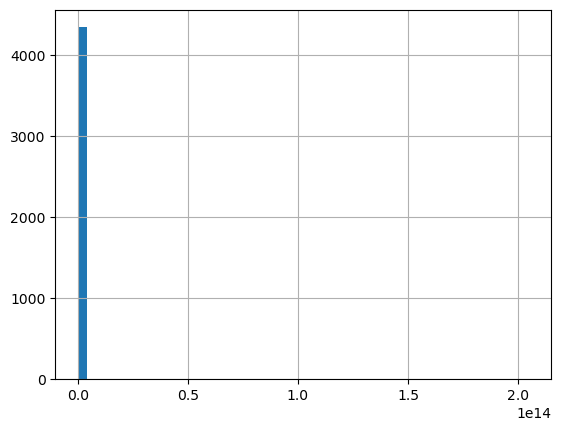

In [50]:
%matplotlib inline
nutrient_ratio['Vitamin E'].hist(bins=50)